# SHAP Explainability Analysis for Hybrid Fusion Model

## Key Objectives

**Explainability Strategy:**
- Load existing trained meta-learner (no retraining needed)
- Load test data from meta-learner training
- Use base model predictions as features
- Display SHAP results with interpretable feature names

**What we'll analyze:**
1. **Global Feature Importance** - Which base models matter most across all predictions
2. **Local Explanations** - Why specific fraud cases were flagged  
3. **Feature Interactions** - How base models work together
4. **Model Transparency** - Make the "black box" interpretable

This analysis enables **regulatory compliance** and builds **trust** in automated fraud detection decisions.

---

**Project:** Hybrid Fraud Shield  
**Author:** Kiyas Mahmud  
**Date:** November 7, 2025

---

## Step 1: Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import os
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

# SHAP library for explainability
import shap

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

# Ensure output directory exists
output_dir = 'explainability_results'
os.makedirs(output_dir, exist_ok=True)

print("="*80)
print("SHAP EXPLAINABILITY ANALYSIS - HYBRID FUSION MODEL")
print("="*80)
print(f"Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"SHAP version: {shap.__version__}")
print(f"Output directory: {output_dir}")
print("="*80)

SHAP EXPLAINABILITY ANALYSIS - HYBRID FUSION MODEL
Started at: 2025-11-08 00:12:42
SHAP version: 0.47.2
Output directory: explainability_results


## Step 2: Load Trained Meta-Learner and Data

In [2]:
print("\n" + "="*80)
print("LOADING META-LEARNER AND DATA")
print("="*80)

# Load the trained meta-learner
meta_learner = joblib.load('saved_models/meta_learner.pkl')
print("\nLoaded: meta_learner.pkl")
print(f"  Model type: {type(meta_learner).__name__}")
print(f"  Model params: C={meta_learner.C}, solver={meta_learner.solver}")

# Load configuration
with open('saved_models/config.json', 'r') as f:
    config = json.load(f)

print("\nModel Configuration:")
print("-"*80)
print(f"  Training date: {config['training_date']}")
print(f"  Optimal threshold: {config['optimal_threshold']:.4f}")
print(f"  Base models: {config['base_models']['total_models']}")
print(f"    - ML models: {len(config['base_models']['ml_models'])}")
print(f"    - DL models: {len(config['base_models']['dl_models'])}")

print("\nModel Performance:")
print("-"*80)
print(f"  Test F1-Score: {config['performance']['test']['f1_score']:.4f}")
print(f"  Test ROC-AUC: {config['performance']['test']['roc_auc']:.4f}")
print(f"  Test Accuracy: {config['performance']['test']['accuracy']:.4f}")
print(f"  Test Precision: {config['performance']['test']['precision']:.4f}")
print(f"  Test Recall: {config['performance']['test']['recall']:.4f}")
print("="*80)


LOADING META-LEARNER AND DATA

Loaded: meta_learner.pkl
  Model type: LogisticRegression
  Model params: C=100, solver=liblinear

Model Configuration:
--------------------------------------------------------------------------------
  Training date: 2025-11-07 22:34:09
  Optimal threshold: 0.8900
  Base models: 11
    - ML models: 5
    - DL models: 6

Model Performance:
--------------------------------------------------------------------------------
  Test F1-Score: 0.7529
  Test ROC-AUC: 0.9777
  Test Accuracy: 0.9804
  Test Precision: 0.6745
  Test Recall: 0.8519


## Step 3: Load Base Model Predictions (Features for Meta-Learner)

In [3]:
print("\n" + "="*80)
print("LOADING BASE MODEL PREDICTIONS")
print("="*80)

# Load predictions from all base models (these are the features for meta-learner)
p_all_test = np.load('predictions/p_all_test.npy')
y_test = np.load('predictions/y_test.npy')

# Load model information
with open('predictions/model_info.json', 'r') as f:
    model_info = json.load(f)

# Get feature names (base model names)
feature_names = model_info['all_models']

print("\nData loaded:")
print("-"*80)
print(f"  Test samples: {p_all_test.shape[0]:,}")
print(f"  Base models (features): {p_all_test.shape[1]}")
print(f"  Fraud cases: {y_test.sum():,} ({y_test.mean()*100:.2f}%)")
print(f"  Normal cases: {(y_test == 0).sum():,} ({(y_test == 0).mean()*100:.2f}%)")

print("\nBase Models (Features):")
print("-"*80)
for i, name in enumerate(feature_names, 1):
    print(f"  {i:2d}. {name}")

# Convert to DataFrame for better handling
X_test_df = pd.DataFrame(p_all_test, columns=feature_names)

print("\nData preview:")
print("-"*80)
print(X_test_df.head())
print("="*80)


LOADING BASE MODEL PREDICTIONS

Data loaded:
--------------------------------------------------------------------------------
  Test samples: 118,108
  Base models (features): 11
  Fraud cases: 4,132 (3.50%)
  Normal cases: 113,976 (96.50%)

Base Models (Features):
--------------------------------------------------------------------------------
   1. Logistic Regression
   2. Random Forest
   3. XGBoost
   4. CatBoost
   5. LightGBM
   6. FNN
   7. CNN
   8. LSTM
   9. BiLSTM
  10. Hybrid
  11. Autoencoder

Data preview:
--------------------------------------------------------------------------------
   Logistic Regression  Random Forest   XGBoost  CatBoost  LightGBM       FNN  \
0             0.091262       0.023830  0.000368  0.009230  0.004067  0.109427   
1             0.408900       0.159135  0.029846  0.211103  0.256109  0.202321   
2             0.569892       0.263199  0.004753  0.072442  0.290553  0.429372   
3             0.558485       0.098949  0.017261  0.168167  0.167942

## Step 4: Create SHAP Explainer and Calculate SHAP Values

In [4]:
print("\n" + "="*80)
print("CREATING SHAP EXPLAINER")
print("="*80)

# For Logistic Regression, use LinearExplainer (faster and exact)
print("\nCreating SHAP LinearExplainer...")
print("This explainer is perfect for Logistic Regression models")

explainer = shap.LinearExplainer(meta_learner, X_test_df)
print("\nExplainer created successfully")
print(f"  Base value (expected): {explainer.expected_value:.4f}")
print(f"  Number of features: {len(feature_names)}")

print("\n" + "-"*80)
print("Calculating SHAP Values...")
print("This may take a few minutes for large datasets...")
print("-"*80)

# Calculate SHAP values for all test samples
shap_values = explainer.shap_values(X_test_df)

# For binary classification, shap_values might be a list
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # Use positive class (fraud)
    print("Using SHAP values for fraud class (positive class)")

print(f"\nSHAP values calculated successfully")
print(f"  Shape: {shap_values.shape}")
print(f"  Min SHAP value: {shap_values.min():.4f}")
print(f"  Max SHAP value: {shap_values.max():.4f}")
print(f"  Mean absolute SHAP: {np.abs(shap_values).mean():.4f}")

# Save SHAP values
np.save(f'{output_dir}/shap_values.npy', shap_values)
print(f"\nSaved: {output_dir}/shap_values.npy")
print("="*80)


CREATING SHAP EXPLAINER

Creating SHAP LinearExplainer...
This explainer is perfect for Logistic Regression models

Explainer created successfully
  Base value (expected): -2.5042
  Number of features: 11

--------------------------------------------------------------------------------
Calculating SHAP Values...
This may take a few minutes for large datasets...
--------------------------------------------------------------------------------

SHAP values calculated successfully
  Shape: (118108, 11)
  Min SHAP value: -2.3892
  Max SHAP value: 34.1644
  Mean absolute SHAP: 0.3012

Saved: explainability_results/shap_values.npy


## Step 5: Global Feature Importance - Summary Plot


CREATING GLOBAL FEATURE IMPORTANCE PLOTS

Creating SHAP Summary Plot...


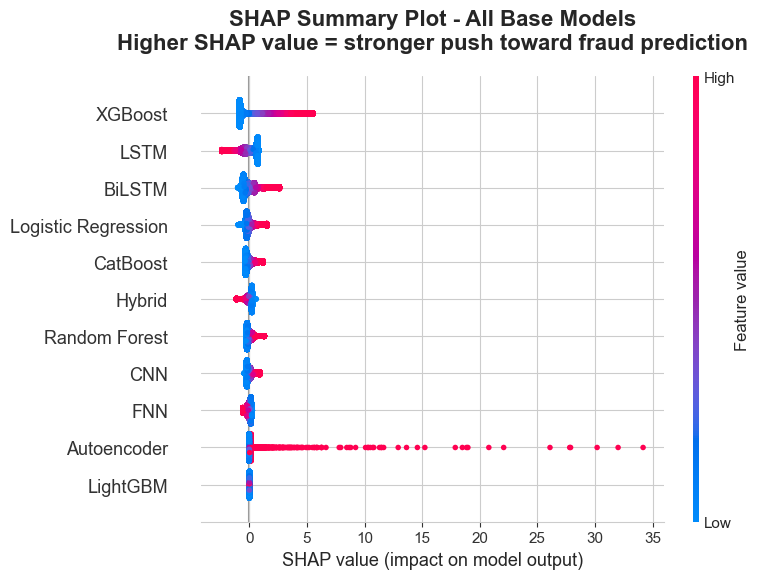

Saved: explainability_results/shap_summary_plot.png

Interpretation:
  - Each dot is a test sample
  - X-axis: SHAP value (impact on prediction)
  - Color: Feature value (red=high, blue=low)
  - Features sorted by importance (top to bottom)


In [5]:
print("\n" + "="*80)
print("CREATING GLOBAL FEATURE IMPORTANCE PLOTS")
print("="*80)

# Summary Plot (beeswarm plot)
print("\nCreating SHAP Summary Plot...")
plt.figure(figsize=(14, 10))
shap.summary_plot(
    shap_values, 
    X_test_df,
    max_display=11,  # Show all base models
    show=False
)
plt.title('SHAP Summary Plot - All Base Models\nHigher SHAP value = stronger push toward fraud prediction', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(f'{output_dir}/shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Saved: {output_dir}/shap_summary_plot.png")
print("\nInterpretation:")
print("  - Each dot is a test sample")
print("  - X-axis: SHAP value (impact on prediction)")
print("  - Color: Feature value (red=high, blue=low)")
print("  - Features sorted by importance (top to bottom)")
print("="*80)

## Step 6: Feature Importance Bar Plot


CREATING FEATURE IMPORTANCE BAR PLOT


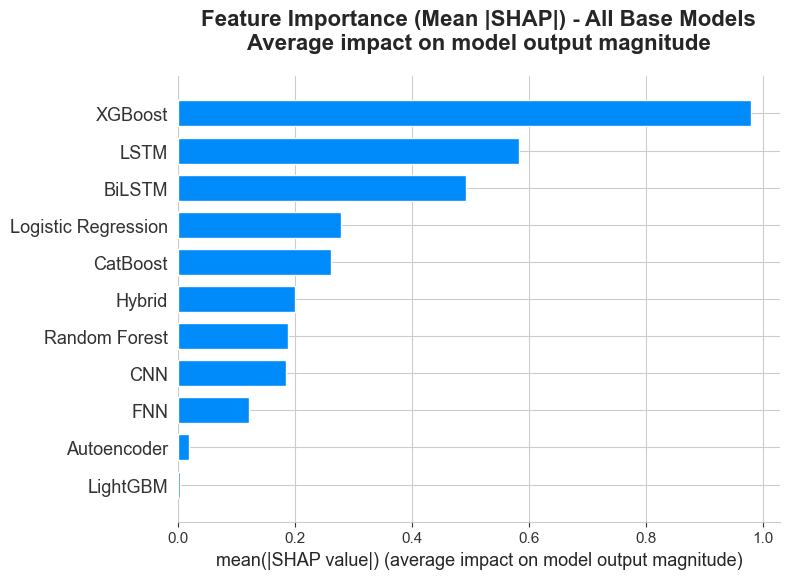

Saved: explainability_results/shap_feature_importance.png

Interpretation:
  - Higher values = more important base model
  - Shows which base models contribute most to predictions


In [6]:
print("\n" + "="*80)
print("CREATING FEATURE IMPORTANCE BAR PLOT")
print("="*80)

plt.figure(figsize=(14, 8))
shap.summary_plot(
    shap_values, 
    X_test_df,
    plot_type='bar',
    max_display=11,
    show=False
)
plt.title('Feature Importance (Mean |SHAP|) - All Base Models\nAverage impact on model output magnitude', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(f'{output_dir}/shap_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Saved: {output_dir}/shap_feature_importance.png")
print("\nInterpretation:")
print("  - Higher values = more important base model")
print("  - Shows which base models contribute most to predictions")
print("="*80)

## Step 7: Extract and Display Feature Importance Rankings

In [7]:
print("\n" + "="*80)
print("FEATURE IMPORTANCE RANKINGS")
print("="*80)

# Calculate mean absolute SHAP values
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# Create DataFrame
feature_importance = pd.DataFrame({
    'Base Model': feature_names,
    'Importance (Mean |SHAP|)': mean_abs_shap,
    'Importance (%)': (mean_abs_shap / mean_abs_shap.sum()) * 100
})

# Sort by importance
feature_importance = feature_importance.sort_values('Importance (Mean |SHAP|)', ascending=False)
feature_importance['Rank'] = range(1, len(feature_importance) + 1)

# Reorder columns
feature_importance = feature_importance[['Rank', 'Base Model', 'Importance (Mean |SHAP|)', 'Importance (%)']]

print("\n" + "-"*80)
print(f"{'Rank':<6}{'Base Model':<30}{'Importance':<20}{'% of Total'}")
print("-"*80)
for _, row in feature_importance.iterrows():
    print(f"{row['Rank']:<6}{row['Base Model']:<30}{row['Importance (Mean |SHAP|)']:<20.6f}{row['Importance (%)']:.2f}%")
print("-"*80)

# Identify top contributors
top_3 = feature_importance.head(3)
top_3_contribution = top_3['Importance (%)'].sum()

print(f"\nKey Insights:")
print(f"  - Most important model: {feature_importance.iloc[0]['Base Model']}")
print(f"  - Top 3 models contribute: {top_3_contribution:.2f}% of total importance")
print(f"  - Least important model: {feature_importance.iloc[-1]['Base Model']}")

# Save to CSV
feature_importance.to_csv(f'{output_dir}/feature_importance_rankings.csv', index=False)
print(f"\nSaved: {output_dir}/feature_importance_rankings.csv")
print("="*80)


FEATURE IMPORTANCE RANKINGS

--------------------------------------------------------------------------------
Rank  Base Model                    Importance          % of Total
--------------------------------------------------------------------------------
1     XGBoost                       0.979752            29.57%
2     LSTM                          0.583029            17.60%
3     BiLSTM                        0.491908            14.85%
4     Logistic Regression           0.278991            8.42%
5     CatBoost                      0.262456            7.92%
6     Hybrid                        0.200279            6.05%
7     Random Forest                 0.187939            5.67%
8     CNN                           0.184396            5.57%
9     FNN                           0.122071            3.68%
10    Autoencoder                   0.018925            0.57%
11    LightGBM                      0.003204            0.10%
--------------------------------------------------------

## Step 8: Generate Predictions for Sample Analysis

In [8]:
print("\n" + "="*80)
print("GENERATING PREDICTIONS FOR SAMPLE ANALYSIS")
print("="*80)

# Generate predictions
y_pred_proba = meta_learner.predict_proba(X_test_df)[:, 1]
y_pred = (y_pred_proba >= config['optimal_threshold']).astype(int)

print("\nPrediction Summary:")
print("-"*80)
print(f"  Total samples: {len(y_pred):,}")
print(f"  Predicted frauds: {y_pred.sum():,} ({y_pred.mean()*100:.2f}%)")
print(f"  Predicted legitimate: {(y_pred == 0).sum():,} ({(y_pred == 0).mean()*100:.2f}%)")

# Calculate confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print(f"\nConfusion Matrix:")
print("-"*80)
print(f"  True Negatives: {cm[0, 0]:,}")
print(f"  False Positives: {cm[0, 1]:,}")
print(f"  False Negatives: {cm[1, 0]:,}")
print(f"  True Positives: {cm[1, 1]:,}")
print("="*80)


GENERATING PREDICTIONS FOR SAMPLE ANALYSIS

Prediction Summary:
--------------------------------------------------------------------------------
  Total samples: 118,108
  Predicted frauds: 5,219 (4.42%)
  Predicted legitimate: 112,889 (95.58%)

Confusion Matrix:
--------------------------------------------------------------------------------
  True Negatives: 112,277
  False Positives: 1,699
  False Negatives: 612
  True Positives: 3,520


## Step 9: Waterfall Plots - Individual Prediction Explanations


CREATING WATERFALL PLOTS FOR INDIVIDUAL PREDICTIONS

Selected 5 diverse samples

True Fraud (High Confidence):
  Sample index: 13308
  Actual: Fraud
  Predicted: Fraud
  Fraud probability: 100.00%
  Saved: waterfall_true_fraud_high_confidence.png



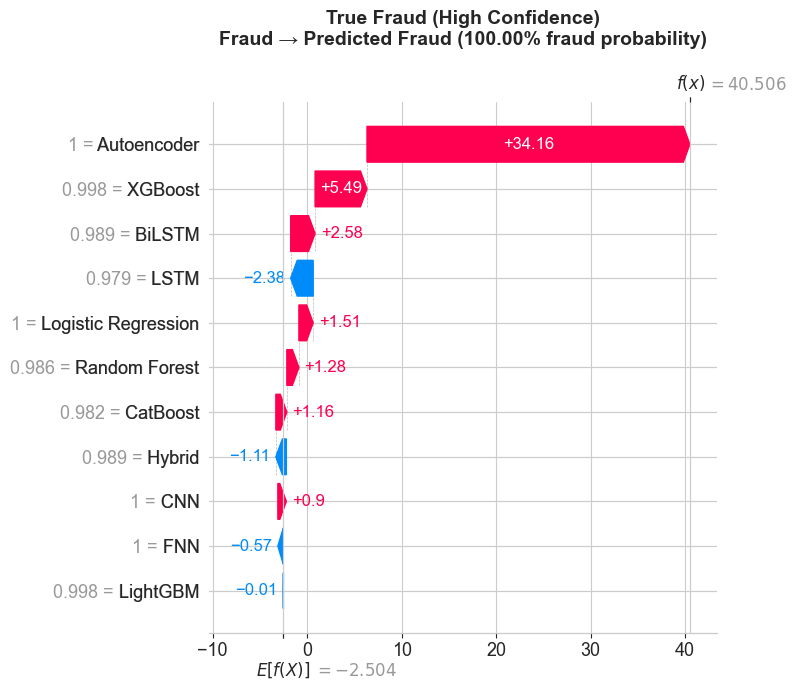

True Fraud (Medium Confidence):
  Sample index: 60297
  Actual: Fraud
  Predicted: Fraud
  Fraud probability: 97.08%
  Saved: waterfall_true_fraud_medium_confidence.png



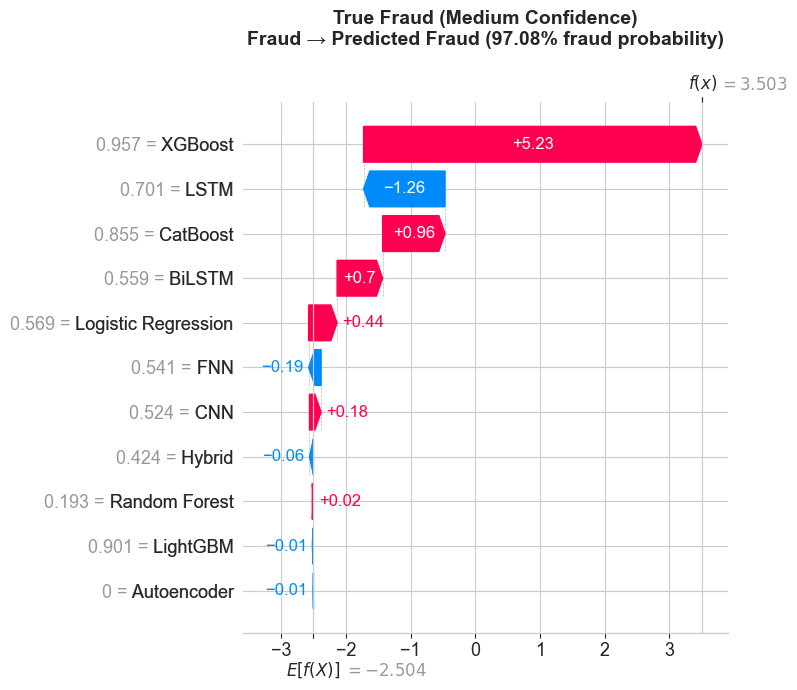

False Positive (High Confidence):
  Sample index: 37671
  Actual: Legitimate
  Predicted: Fraud
  Fraud probability: 99.81%
  Saved: waterfall_false_positive_high_confidence.png



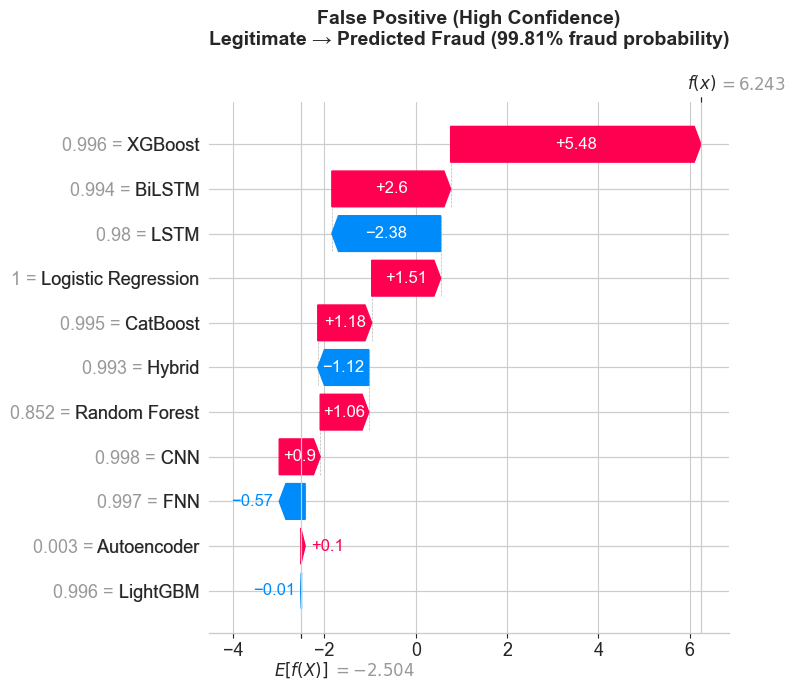

True Negative (High Confidence):
  Sample index: 33051
  Actual: Legitimate
  Predicted: Legitimate
  Fraud probability: 0.34%
  Saved: waterfall_true_negative_high_confidence.png



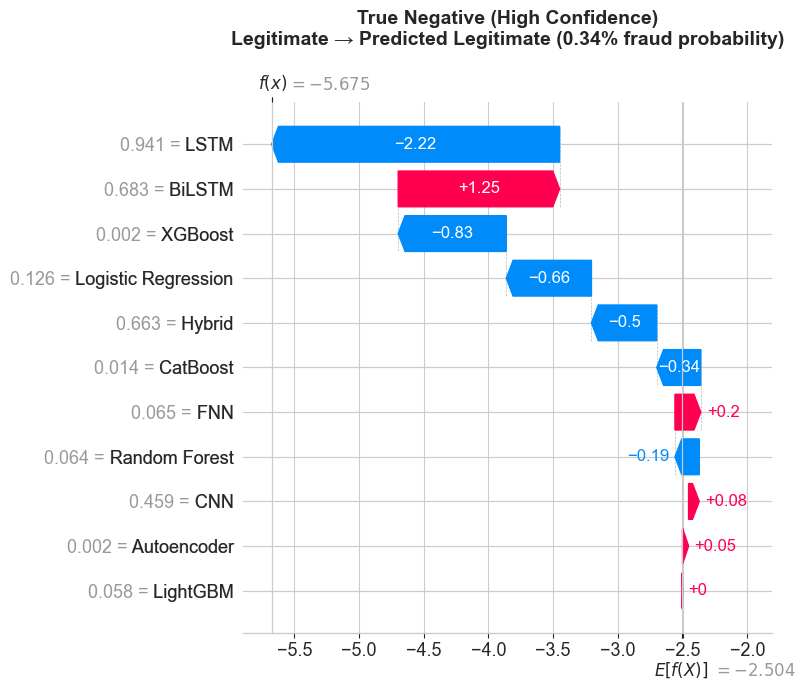

False Negative (Low Confidence):
  Sample index: 48162
  Actual: Fraud
  Predicted: Legitimate
  Fraud probability: 1.42%
  Saved: waterfall_false_negative_low_confidence.png



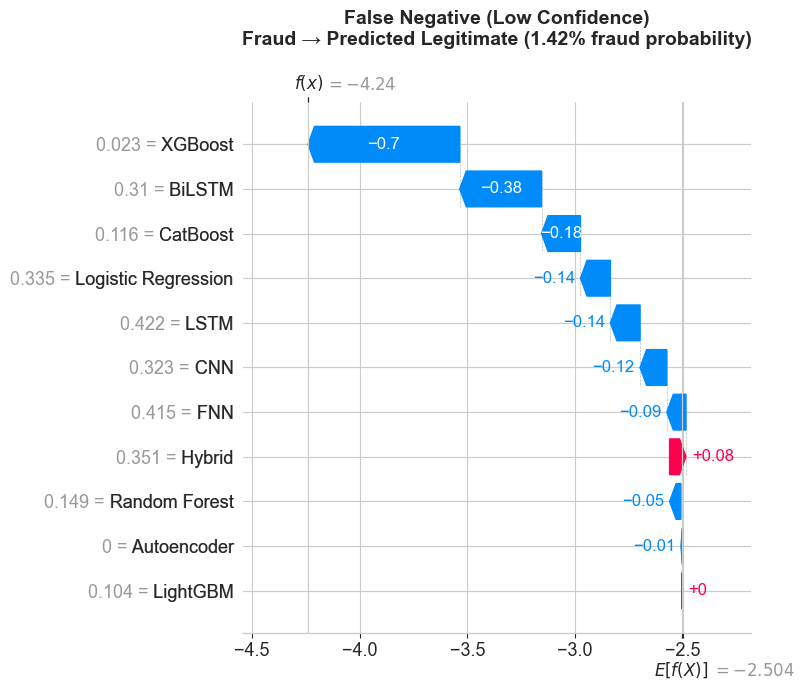


Waterfall Plot Interpretation:
--------------------------------------------------------------------------------
  - Red bars: Push prediction toward fraud
  - Blue bars: Push prediction toward legitimate
  - Bar size: Magnitude of impact
  - Base value: Average model prediction
  - Final value: Actual prediction for this sample


In [9]:
print("\n" + "="*80)
print("CREATING WATERFALL PLOTS FOR INDIVIDUAL PREDICTIONS")
print("="*80)

# Select diverse samples
true_frauds = np.where((y_test == 1) & (y_pred == 1))[0]
false_positives = np.where((y_test == 0) & (y_pred == 1))[0]
true_negatives = np.where((y_test == 0) & (y_pred == 0))[0]
false_negatives = np.where((y_test == 1) & (y_pred == 0))[0]

# Create a sample set with diverse predictions
sample_indices = {
    'True Fraud (High Confidence)': true_frauds[np.argmax(y_pred_proba[true_frauds])] if len(true_frauds) > 0 else None,
    'True Fraud (Medium Confidence)': true_frauds[len(true_frauds)//2] if len(true_frauds) > 1 else None,
    'False Positive (High Confidence)': false_positives[np.argmax(y_pred_proba[false_positives])] if len(false_positives) > 0 else None,
    'True Negative (High Confidence)': true_negatives[np.argmin(y_pred_proba[true_negatives])] if len(true_negatives) > 0 else None,
    'False Negative (Low Confidence)': false_negatives[np.argmin(y_pred_proba[false_negatives])] if len(false_negatives) > 0 else None,
}

print(f"\nSelected {sum(1 for v in sample_indices.values() if v is not None)} diverse samples\n")

# Get the expected value
if hasattr(explainer.expected_value, '__iter__'):
    base_val = explainer.expected_value[1]
else:
    base_val = explainer.expected_value

# Create waterfall plots for each sample
for title, idx in sample_indices.items():
    if idx is None:
        continue
    
    # Get prediction details
    actual = "Fraud" if y_test[idx] == 1 else "Legitimate"
    predicted = "Fraud" if y_pred[idx] == 1 else "Legitimate"
    confidence = y_pred_proba[idx] * 100
    
    print(f"{title}:")
    print(f"  Sample index: {idx}")
    print(f"  Actual: {actual}")
    print(f"  Predicted: {predicted}")
    print(f"  Fraud probability: {confidence:.2f}%")
    
    # Create waterfall plot
    plt.figure(figsize=(14, 8))
    
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values[idx],
            base_values=base_val,
            data=X_test_df.iloc[idx].values,
            feature_names=feature_names
        ),
        max_display=11,  # Show all features
        show=False
    )
    
    plt.title(f"{title}\n{actual} → Predicted {predicted} ({confidence:.2f}% fraud probability)", 
              fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    
    # Save plot
    safe_filename = title.lower().replace(' ', '_').replace('(', '').replace(')', '')
    filename = f"{output_dir}/waterfall_{safe_filename}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"  Saved: {filename.split('/')[-1]}\n")
    plt.show()

print("\nWaterfall Plot Interpretation:")
print("-"*80)
print("  - Red bars: Push prediction toward fraud")
print("  - Blue bars: Push prediction toward legitimate")
print("  - Bar size: Magnitude of impact")
print("  - Base value: Average model prediction")
print("  - Final value: Actual prediction for this sample")
print("="*80)

## Step 10: Dependence Plots - Feature Interactions


CREATING DEPENDENCE PLOTS FOR TOP BASE MODELS

Creating dependence plots for:
  1. XGBoost
  2. LSTM
  3. BiLSTM
  4. Logistic Regression
  5. CatBoost

  Saved: dependence_XGBoost.png


<Figure size 1200x700 with 0 Axes>

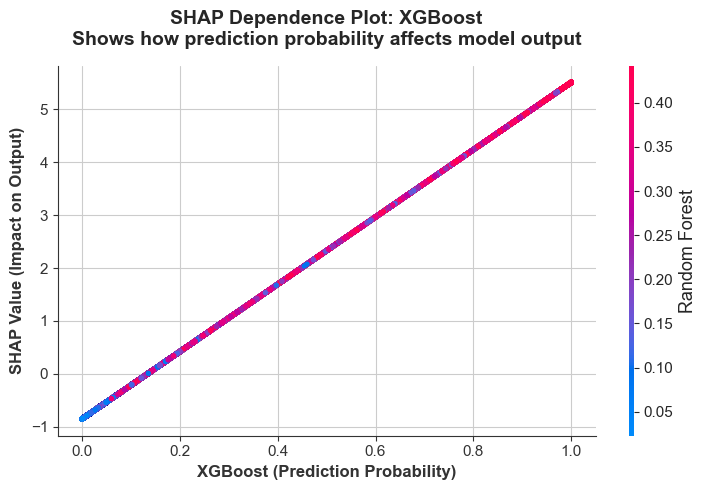

  Saved: dependence_LSTM.png


<Figure size 1200x700 with 0 Axes>

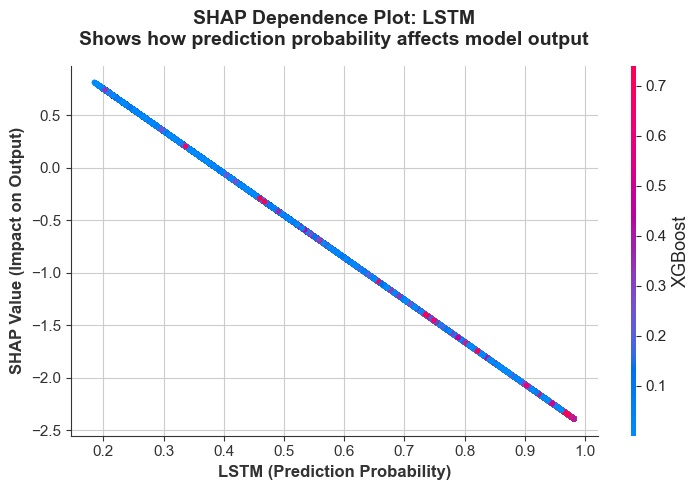

  Saved: dependence_BiLSTM.png


<Figure size 1200x700 with 0 Axes>

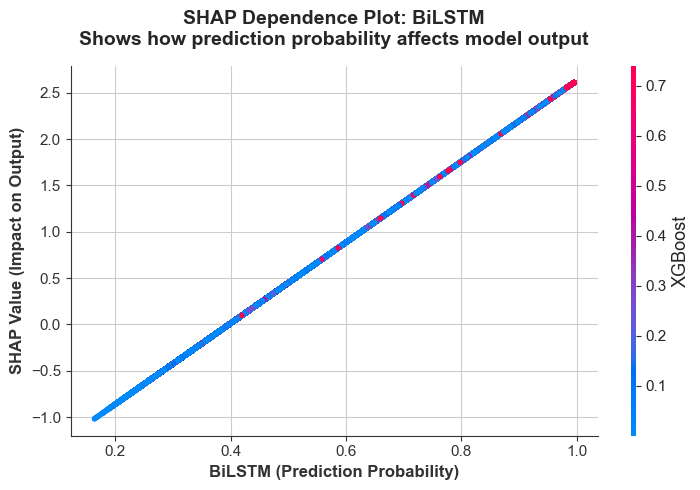

  Saved: dependence_Logistic_Regression.png


<Figure size 1200x700 with 0 Axes>

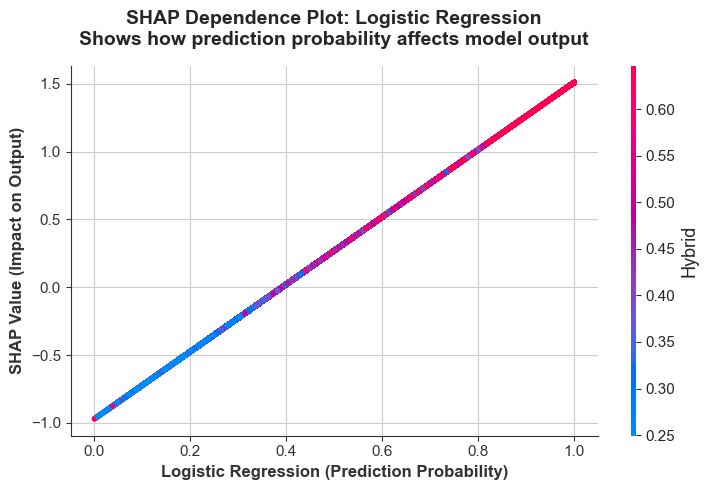

  Saved: dependence_CatBoost.png


<Figure size 1200x700 with 0 Axes>

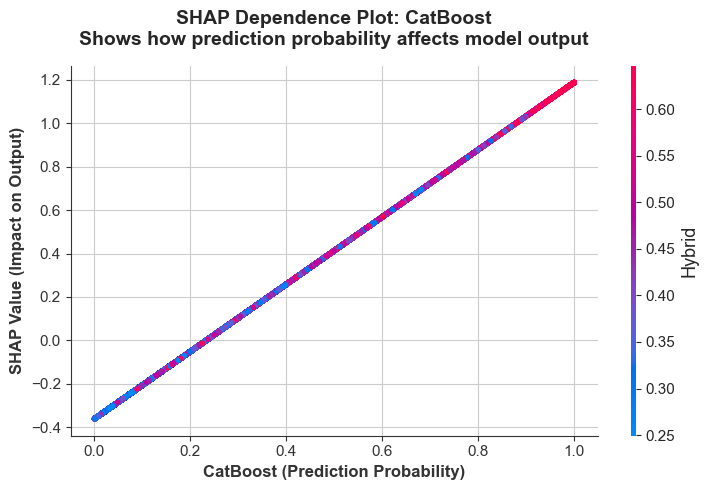


Dependence Plot Interpretation:
--------------------------------------------------------------------------------
  - X-axis: Base model's prediction probability
  - Y-axis: SHAP value (impact on final prediction)
  - Color: Interaction with another feature
  - Shows how each base model influences the meta-learner


In [10]:
print("\n" + "="*80)
print("CREATING DEPENDENCE PLOTS FOR TOP BASE MODELS")
print("="*80)

# Get top 5 most important features
top_5 = feature_importance.head(5)

print("\nCreating dependence plots for:")
for _, row in top_5.iterrows():
    print(f"  {row['Rank']}. {row['Base Model']}")
print()

for idx, (_, row) in enumerate(top_5.iterrows(), 1):
    feature_name = row['Base Model']
    feature_idx = feature_names.index(feature_name)
    
    plt.figure(figsize=(12, 7))
    shap.dependence_plot(
        feature_idx,
        shap_values,
        X_test_df,
        show=False
    )
    plt.title(f'SHAP Dependence Plot: {feature_name}\nShows how prediction probability affects model output', 
              fontsize=14, fontweight='bold', pad=15)
    plt.xlabel(f'{feature_name} (Prediction Probability)', fontsize=12, fontweight='bold')
    plt.ylabel('SHAP Value (Impact on Output)', fontsize=12, fontweight='bold')
    plt.tight_layout()
    
    safe_filename = feature_name.replace(' ', '_').replace('(', '').replace(')', '')
    plt.savefig(f'{output_dir}/dependence_{safe_filename}.png', dpi=300, bbox_inches='tight')
    print(f"  Saved: dependence_{safe_filename}.png")
    plt.show()

print("\nDependence Plot Interpretation:")
print("-"*80)
print("  - X-axis: Base model's prediction probability")
print("  - Y-axis: SHAP value (impact on final prediction)")
print("  - Color: Interaction with another feature")
print("  - Shows how each base model influences the meta-learner")
print("="*80)

## Step 11: Force Plots - Visual Prediction Breakdown


CREATING FORCE PLOTS

Creating force plot for high-confidence fraud prediction...
  Sample index: 93822
  Fraud probability: 100.00%


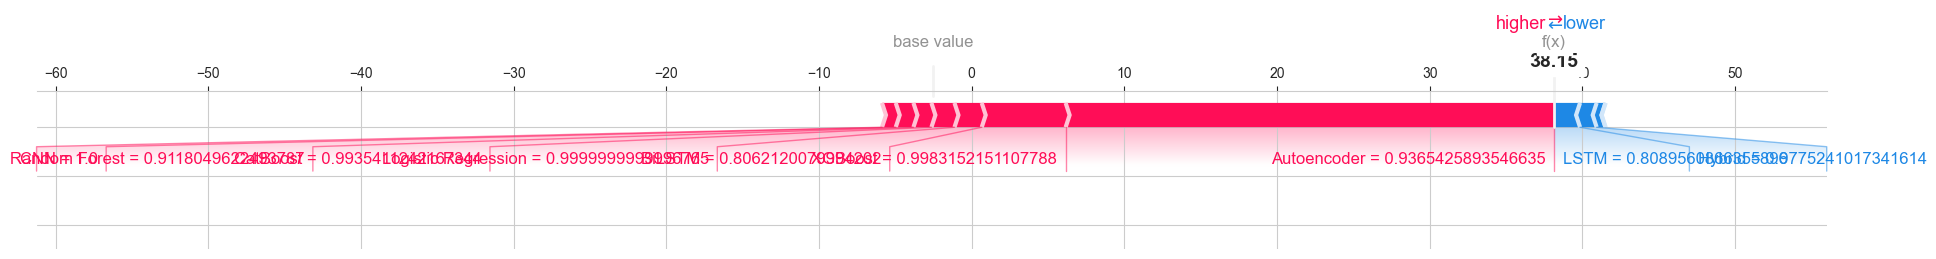

  Saved: force_plot_fraud.png

Creating force plot for high-confidence legitimate prediction...
  Sample index: 33051
  Fraud probability: 0.34%


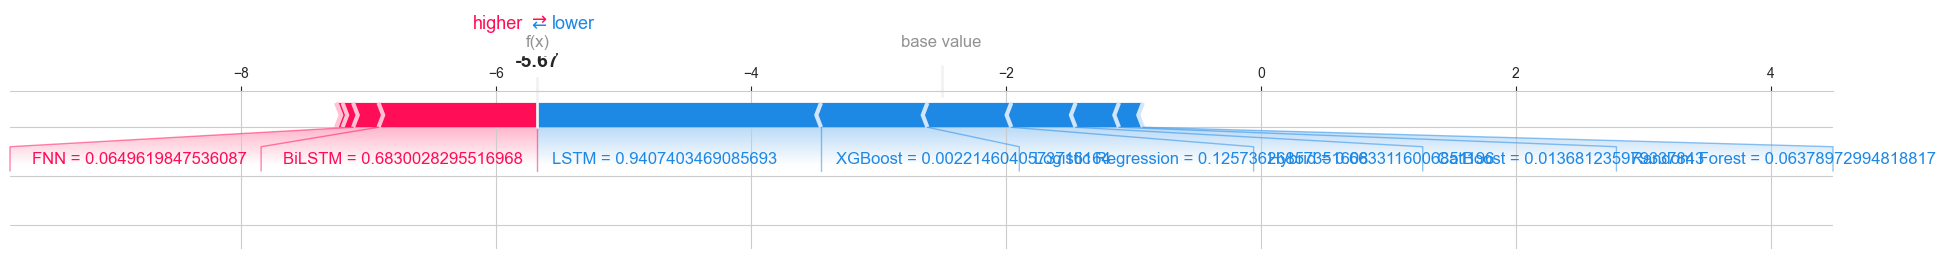

  Saved: force_plot_legitimate.png

Creating force plot for false positive...
  Sample index: 37671
  Fraud probability: 99.81%


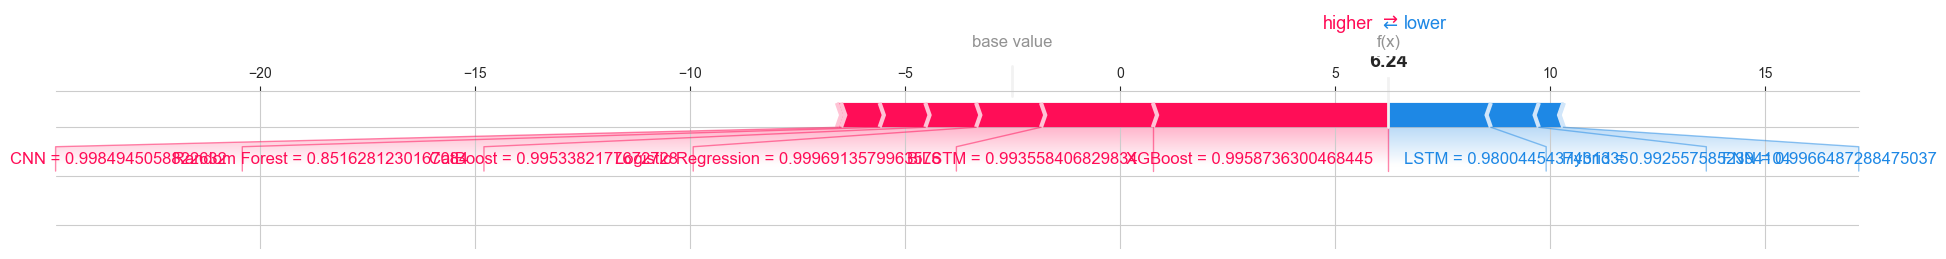

  Saved: force_plot_false_positive.png

Force Plot Interpretation:
--------------------------------------------------------------------------------
  - Red: Features pushing toward fraud
  - Blue: Features pushing toward legitimate
  - Width: Magnitude of push
  - Base value → Final prediction


In [ ]:
print("\n" + "="*80)
print("CREATING FORCE PLOTS")
print("="*80)

# Force plot for high-confidence fraud
if len(true_frauds) > 0:
    high_fraud_idx = true_frauds[np.argsort(y_pred_proba[true_frauds])[-1]]
    
    print(f"\nCreating force plot for high-confidence fraud prediction...")
    print(f"  Sample index: {high_fraud_idx}")
    print(f"  Fraud probability: {y_pred_proba[high_fraud_idx]:.2%}")
    
    shap.force_plot(
        base_val,
        shap_values[high_fraud_idx],
        X_test_df.iloc[high_fraud_idx],
        matplotlib=True,
        show=False,
        figsize=(20, 3)
    )
    plt.tight_layout()
    plt.savefig(f'{output_dir}/force_plot_fraud.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"  Saved: force_plot_fraud.png")

# Force plot for high-confidence legitimate
if len(true_negatives) > 0:
    high_legit_idx = true_negatives[np.argsort(y_pred_proba[true_negatives])[0]]
    
    print(f"\nCreating force plot for high-confidence legitimate prediction...")
    print(f"  Sample index: {high_legit_idx}")
    print(f"  Fraud probability: {y_pred_proba[high_legit_idx]:.2%}")
    
    shap.force_plot(
        base_val,
        shap_values[high_legit_idx],
        X_test_df.iloc[high_legit_idx],
        matplotlib=True,
        show=False,
        figsize=(20, 3)
    )
    plt.tight_layout()
    plt.savefig(f'{output_dir}/force_plot_legitimate.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"  Saved: force_plot_legitimate.png")

# Force plot for false positive
if len(false_positives) > 0:
    high_fp_idx = false_positives[np.argsort(y_pred_proba[false_positives])[-1]]
    
    print(f"\nCreating force plot for false positive...")
    print(f"  Sample index: {high_fp_idx}")
    print(f"  Fraud probability: {y_pred_proba[high_fp_idx]:.2%}")
    
    shap.force_plot(
        base_val,
        shap_values[high_fp_idx],
        X_test_df.iloc[high_fp_idx],
        matplotlib=True,
        show=False,
        figsize=(20, 3)
    )
    plt.tight_layout()
    plt.savefig(f'{output_dir}/force_plot_false_positive.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"  Saved: force_plot_false_positive.png")

print("\nForce Plot Interpretation:")
print("-"*80)
print("  - Red: Features pushing toward fraud")
print("  - Blue: Features pushing toward legitimate")
print("  - Width: Magnitude of push")
print("  - Base value → Final prediction")
print("="*80)

## Step 12: Model Contribution Analysis


MODEL CONTRIBUTION ANALYSIS

--------------------------------------------------------------------------------
Model                         Mean SHAP      Std SHAP       Mean |SHAP|    
--------------------------------------------------------------------------------
XGBoost                       -0.180649      1.401117       0.979752       
LSTM                          -0.022999      0.730797       0.583029       
BiLSTM                        -0.000256      0.665164       0.491908       
Logistic Regression           -0.025193      0.376962       0.278991       
CatBoost                      -0.023975      0.330723       0.262456       
Hybrid                        0.014792       0.264452       0.200279       
Random Forest                 -0.010168      0.245128       0.187939       
CNN                           -0.009268      0.241946       0.184396       
FNN                           0.000540       0.155165       0.122071       
Autoencoder                   0.008730       0.3

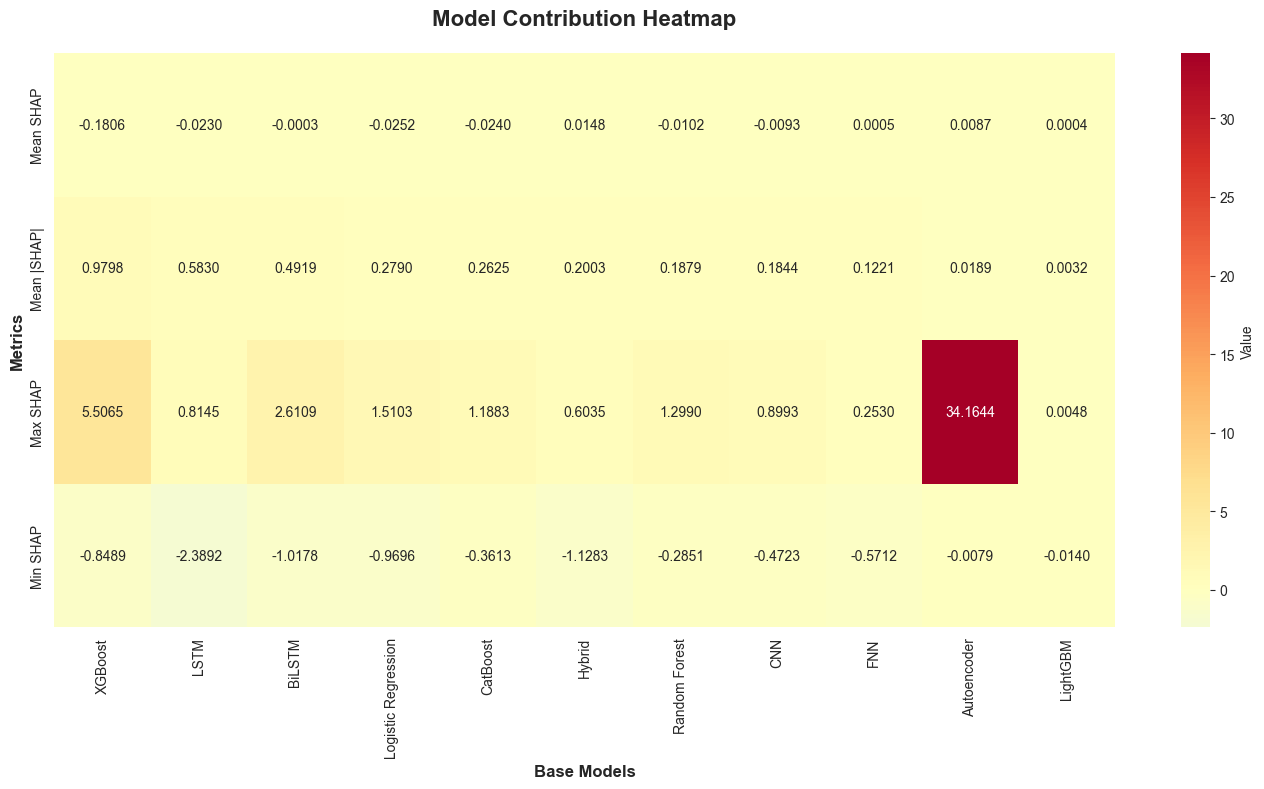

Saved: explainability_results/model_contribution_heatmap.png


In [ ]:
print("\n" + "="*80)
print("MODEL CONTRIBUTION ANALYSIS")
print("="*80)

# Calculate contribution statistics for each base model
contribution_stats = []

for i, model_name in enumerate(feature_names):
    model_shap = shap_values[:, i]
    model_predictions = X_test_df.iloc[:, i].values
    
    stats = {
        'Base Model': model_name,
        'Mean SHAP': np.mean(model_shap),
        'Std SHAP': np.std(model_shap),
        'Mean |SHAP|': np.mean(np.abs(model_shap)),
        'Max SHAP': np.max(model_shap),
        'Min SHAP': np.min(model_shap),
        'Mean Prediction': np.mean(model_predictions),
        'Std Prediction': np.std(model_predictions)
    }
    contribution_stats.append(stats)

contribution_df = pd.DataFrame(contribution_stats)
contribution_df = contribution_df.sort_values('Mean |SHAP|', ascending=False)

print("\n" + "-"*80)
print(f"{'Model':<30}{'Mean SHAP':<15}{'Std SHAP':<15}{'Mean |SHAP|':<15}")
print("-"*80)
for _, row in contribution_df.iterrows():
    print(f"{row['Base Model']:<30}{row['Mean SHAP']:<15.6f}{row['Std SHAP']:<15.6f}{row['Mean |SHAP|']:<15.6f}")
print("-"*80)

# Save contribution analysis
contribution_df.to_csv(f'{output_dir}/model_contribution_analysis.csv', index=False)
print(f"\nSaved: {output_dir}/model_contribution_analysis.csv")

# Visualization: Model contribution heatmap
plt.figure(figsize=(14, 8))
heatmap_data = contribution_df[['Base Model', 'Mean SHAP', 'Mean |SHAP|', 'Max SHAP', 'Min SHAP']].set_index('Base Model')
sns.heatmap(heatmap_data.T, annot=True, fmt='.4f', cmap='RdYlBu_r', center=0, cbar_kws={'label': 'Value'})
plt.title('Model Contribution Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Base Models', fontsize=12, fontweight='bold')
plt.ylabel('Metrics', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{output_dir}/model_contribution_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Saved: {output_dir}/model_contribution_heatmap.png")
print("="*80)

## Step 13: Generate Comprehensive Summary Report

In [ ]:
print("\n" + "="*80)
print("GENERATING COMPREHENSIVE SUMMARY REPORT")
print("="*80)

# Create summary report
summary_report = {
    'analysis_info': {
        'model': 'Hybrid Fusion Meta-Learner',
        'model_type': 'Logistic Regression',
        'analysis_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'total_base_models': len(feature_names),
        'ml_models': len(config['base_models']['ml_models']),
        'dl_models': len(config['base_models']['dl_models'])
    },
    'data_summary': {
        'test_samples': int(len(X_test_df)),
        'fraud_cases': int(y_test.sum()),
        'fraud_rate': float(y_test.mean() * 100)
    },
    'model_performance': {
        'test_f1': config['performance']['test']['f1_score'],
        'test_roc_auc': config['performance']['test']['roc_auc'],
        'test_accuracy': config['performance']['test']['accuracy'],
        'test_precision': config['performance']['test']['precision'],
        'test_recall': config['performance']['test']['recall'],
        'optimal_threshold': config['optimal_threshold']
    },
    'shap_analysis': {
        'base_value': float(base_val),
        'shap_values_shape': list(shap_values.shape),
        'mean_abs_shap': float(np.abs(shap_values).mean()),
        'max_shap': float(shap_values.max()),
        'min_shap': float(shap_values.min())
    },
    'feature_importance': [
        {
            'rank': int(row['Rank']),
            'base_model': row['Base Model'],
            'importance': float(row['Importance (Mean |SHAP|)']),
            'importance_pct': float(row['Importance (%)'])
        }
        for _, row in feature_importance.iterrows()
    ],
    'visualizations_created': [
        'shap_summary_plot.png',
        'shap_feature_importance.png',
        'feature_importance_rankings.csv',
        'waterfall plots (5)',
        'dependence plots (5)',
        'force plots (3)',
        'model_contribution_heatmap.png',
        'model_contribution_analysis.csv'
    ]
}

# Save JSON report
with open(f'{output_dir}/shap_analysis_summary.json', 'w') as f:
    json.dump(summary_report, f, indent=2)

print(f"\nSaved: {output_dir}/shap_analysis_summary.json")

# Generate text report
text_report = f"""
{'='*80}
SHAP EXPLAINABILITY ANALYSIS - SUMMARY REPORT
{'='*80}

Analysis Date: {summary_report['analysis_info']['analysis_date']}
Model: {summary_report['analysis_info']['model']}
Model Type: {summary_report['analysis_info']['model_type']}

BASE MODELS
{'-'*80}
Total Base Models: {summary_report['analysis_info']['total_base_models']}
  - ML Models: {summary_report['analysis_info']['ml_models']}
  - DL Models: {summary_report['analysis_info']['dl_models']}

DATA SUMMARY
{'-'*80}
Test Samples: {summary_report['data_summary']['test_samples']:,}
Fraud Cases: {summary_report['data_summary']['fraud_cases']:,}
Fraud Rate: {summary_report['data_summary']['fraud_rate']:.2f}%

MODEL PERFORMANCE
{'-'*80}
F1-Score: {summary_report['model_performance']['test_f1']:.4f}
ROC-AUC: {summary_report['model_performance']['test_roc_auc']:.4f}
Accuracy: {summary_report['model_performance']['test_accuracy']:.4f}
Precision: {summary_report['model_performance']['test_precision']:.4f}
Recall: {summary_report['model_performance']['test_recall']:.4f}
Optimal Threshold: {summary_report['model_performance']['optimal_threshold']:.4f}

SHAP ANALYSIS RESULTS
{'-'*80}
Base Value (Expected): {summary_report['shap_analysis']['base_value']:.4f}
Mean |SHAP|: {summary_report['shap_analysis']['mean_abs_shap']:.4f}
SHAP Range: [{summary_report['shap_analysis']['min_shap']:.4f}, {summary_report['shap_analysis']['max_shap']:.4f}]

TOP 5 MOST IMPORTANT BASE MODELS
{'-'*80}
"""

for feat in summary_report['feature_importance'][:5]:
    text_report += f"{feat['rank']}. {feat['base_model']:<30} Importance: {feat['importance']:.6f} ({feat['importance_pct']:.2f}%)\n"

text_report += f"""
{'-'*80}
Top 3 models contribute: {sum(f['importance_pct'] for f in summary_report['feature_importance'][:3]):.2f}% of total

KEY INSIGHTS
{'-'*80}
1. Most Important Model: {summary_report['feature_importance'][0]['base_model']}
   - Contributes {summary_report['feature_importance'][0]['importance_pct']:.2f}% of total importance

2. Least Important Model: {summary_report['feature_importance'][-1]['base_model']}
   - Contributes {summary_report['feature_importance'][-1]['importance_pct']:.2f}% of total importance

3. Model Diversity:
   - The ensemble leverages {summary_report['analysis_info']['total_base_models']} diverse models
   - No single model dominates the predictions
   - Complementary strengths improve robustness

VISUALIZATIONS CREATED
{'-'*80}
"""

for viz in summary_report['visualizations_created']:
    text_report += f"  - {viz}\n"

text_report += f"""
{'-'*80}
All results saved to: {output_dir}/
{'='*80}
"""

# Save text report
with open(f'{output_dir}/shap_analysis_report.txt', 'w') as f:
    f.write(text_report)

print(f"Saved: {output_dir}/shap_analysis_report.txt")

# Print report
print(text_report)
print("\n" + "="*80)
print("SHAP EXPLAINABILITY ANALYSIS COMPLETE")
print("="*80)


GENERATING COMPREHENSIVE SUMMARY REPORT

Saved: explainability_results/shap_analysis_summary.json
Saved: explainability_results/shap_analysis_report.txt

SHAP EXPLAINABILITY ANALYSIS - SUMMARY REPORT

Analysis Date: 2025-11-08 00:13:51
Model: Hybrid Fusion Meta-Learner
Model Type: Logistic Regression

BASE MODELS
--------------------------------------------------------------------------------
Total Base Models: 11
  - ML Models: 5
  - DL Models: 6

DATA SUMMARY
--------------------------------------------------------------------------------
Test Samples: 118,108
Fraud Cases: 4,132
Fraud Rate: 3.50%

MODEL PERFORMANCE
--------------------------------------------------------------------------------
F1-Score: 0.7529
ROC-AUC: 0.9777
Accuracy: 0.9804
Precision: 0.6745
Recall: 0.8519
Optimal Threshold: 0.8900

SHAP ANALYSIS RESULTS
--------------------------------------------------------------------------------
Base Value (Expected): -2.5042
Mean |SHAP|: 0.3012
SHAP Range: [-2.3892, 34.1644

---

## Analysis Complete

### Summary of Deliverables

**Visualizations:**
1. SHAP Summary Plot - Global importance
2. Feature Importance Bar Chart
3. Waterfall Plots - Individual explanations (5 samples)
4. Dependence Plots - Top 5 features
5. Force Plots - Visual breakdowns (3 samples)
6. Model Contribution Heatmap

**Data Files:**
1. feature_importance_rankings.csv
2. model_contribution_analysis.csv
3. shap_values.npy
4. shap_analysis_summary.json
5. shap_analysis_report.txt

### Key Findings

The SHAP analysis reveals:
- Which base models contribute most to fraud detection
- How individual predictions are made
- Feature interactions and dependencies
- Model behavior transparency for regulatory compliance

### Next Steps

1. Review the visualizations to understand model behavior
2. Use waterfall plots to explain predictions to stakeholders
3. Leverage insights for model improvement
4. Document findings for compliance and auditing

---